### Study of automatic evaluation metrics applied to story generation in relation to human metrics
Notebook from Desbois and Millet (2023)

In [1]:
from data_factory.params import list_columns_name
import pandas as pd

from metric_factory.params import list_metric_AEM, list_metric_human, list_metric_MENLI, list_model_MENLI
from data_factory.params import list_columns_name, list_models_to_keep
from metric_factory.utils import get_X_Y, compute_lgb_reg, compute_cv_lgb, get_scores  
from data_factory.cleaning import clean_ann, clean_scoring, clean_menli, merge_scoring_menli, merge_ann_scoring
import lightgbm as lgb   

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df_ann = pd.read_csv('https://raw.githubusercontent.com/dig-team/hanna-benchmark-asg/main/hanna_stories_annotations.csv')
df_scoring = pd.read_csv('https://raw.githubusercontent.com/dig-team/hanna-benchmark-asg/main/hanna_metric_scores.csv')

#from metric_factory.menli import compute_menli
#df_menli = compute_menli(df)
# for computation time reasons, we saved the output of compute_menli as a csv
df_menli = pd.read_csv("metric_factory/df_MENLI.csv", index_col=[0])

df_ann = clean_ann(df_ann, list_models_to_keep)
df_scoring = clean_scoring(df_scoring, list_columns_name, list_models_to_keep)
df_menli_clean = clean_menli(df_menli)
df_all_scoring = merge_scoring_menli(df_scoring, df_menli_clean)
df_complete = merge_ann_scoring(df_ann, df_all_scoring, list_models_to_keep)



### Correlation between automatic metrics and human metrics

In [2]:
from data_factory.params import (list_models_to_keep, liste_human_score,liste_metric, list_metric_to_keep_max, list_metric_to_keep_min,cmap_red_green_red)
from corr_and_kendall_factory.visualizations import (print_correlation_map, print_max_min_heatmap,print_score_heatmap, taukendall_complementarity_visualization)
from corr_and_kendall_factory.utils import (create_min_max_scaled_data_without_human_model, create_df_all_ranked, compute_metrics_complementarity)

In [3]:
mean_complete = df_complete.groupby("Model")[liste_human_score + liste_metric].mean().reindex(index = list_models_to_keep)
mean_complete.head(5)

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,BLEU,ROUGE-1 F-Score,METEOR,chrF,...,S3-Pyramid,InfoLM-FisherRao,BARTScore-SH,SUPERT-Golden,BLANC-Golden,MENLI_x_BERT,MENLI_x_Mover,SummaQA,Novelty-1,Repetition-1
Model,,,,,,,,,,,,,,,,,,,,,
Human,4.170139,4.427083,3.222222,3.152778,3.881944,3.729167,100.000000,1.000000,1.000000,100.000000,...,1.390799,0.000241,-1.211944,0.841640,0.595298,0.622197,0.901708,0.218905,0.947112,0.295346
BertGeneration,2.458333,3.142361,2.284722,2.090278,2.670139,2.409722,0.737315,0.264094,0.096491,24.774296,...,0.087592,2.745755,-4.795655,0.337677,0.007037,0.371961,0.380973,0.079222,0.924797,0.283689
CTRL,2.538194,2.927083,2.260417,1.934028,2.534722,2.225694,0.783827,0.262194,0.095976,23.243800,...,0.090673,2.696473,-4.810966,0.338329,0.002692,0.330582,0.381232,0.086443,0.921951,0.303845
GPT-2,2.809028,3.288194,2.472222,2.208333,2.861111,2.677083,1.095885,0.311902,0.130549,32.231391,...,0.175993,2.721316,-4.734640,0.352610,0.001037,0.440981,0.385254,0.092916,0.935271,0.311258
RoBERTa,2.541667,3.215278,2.267361,2.125000,2.739583,2.409722,0.733557,0.258686,0.092242,23.932329,...,0.081605,2.752807,-4.816065,0.335860,0.004666,0.409505,0.333556,0.070982,0.924091,0.267270


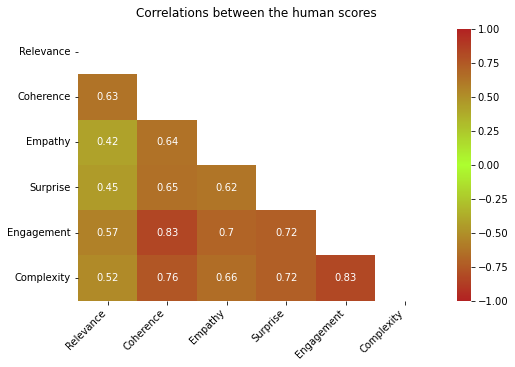

In [4]:
print_correlation_map(df_complete[liste_human_score], cmap_red_green_red, (8,5), title='Correlations between the human scores', annot=True)

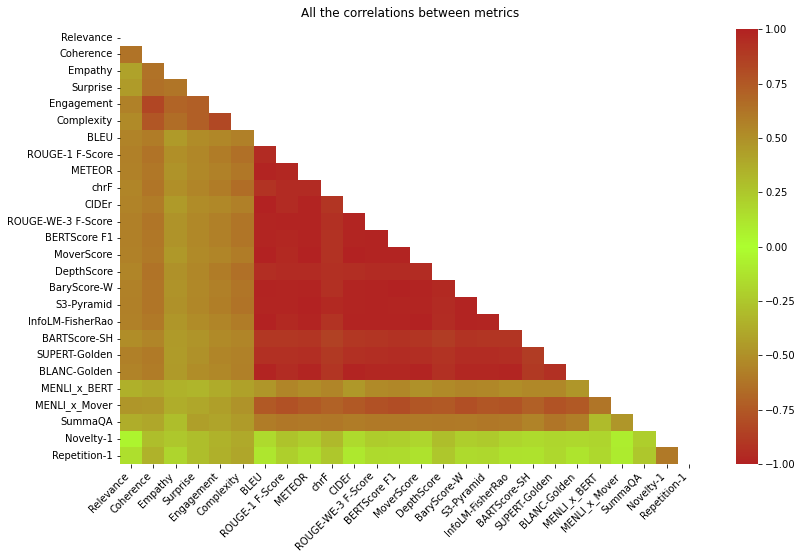

In [5]:
print_correlation_map(df_complete[liste_human_score + liste_metric], cmap_red_green_red, (13, 8), title = "All the correlations between metrics", annot= False)

(<Figure size 1296x504 with 1 Axes>, <AxesSubplot:ylabel='Model'>)

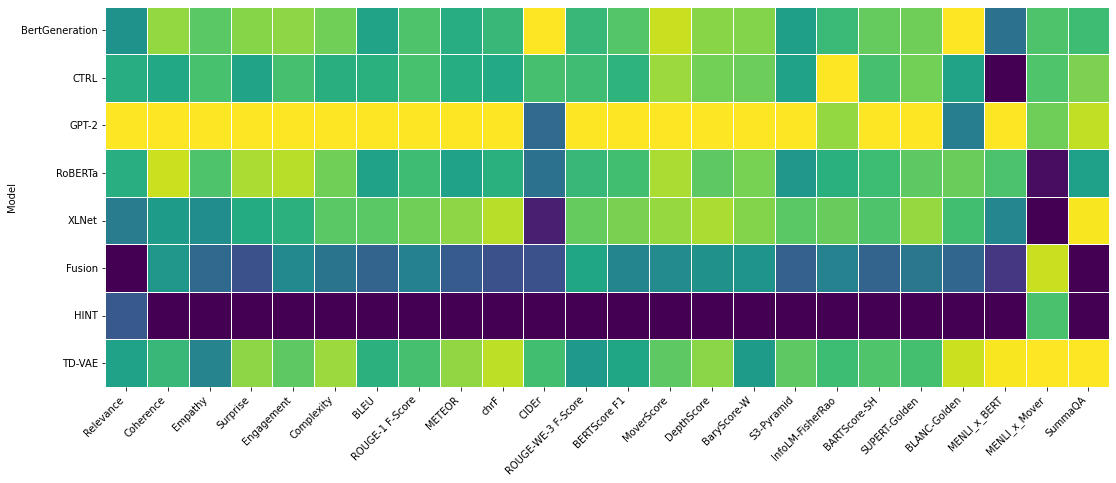

In [6]:
df_min_max_scaled  = create_min_max_scaled_data_without_human_model(liste_metric, df_complete, liste_human_score, list_metric_to_keep_min, list_models_to_keep)
print_max_min_heatmap(df_min_max_scaled)

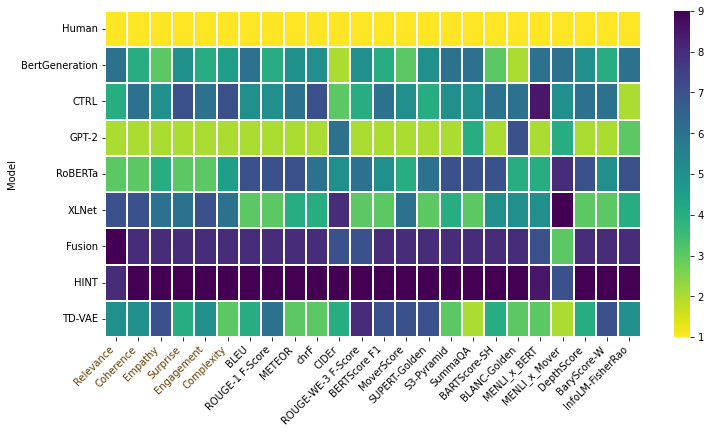

In [7]:
df_all_ranked = create_df_all_ranked(mean_complete, list_metric_to_keep_max, list_metric_to_keep_min)
print_score_heatmap(df_all_ranked)

In [8]:
taukendall_corr = compute_metrics_complementarity(df_complete, liste_human_score, liste_metric)

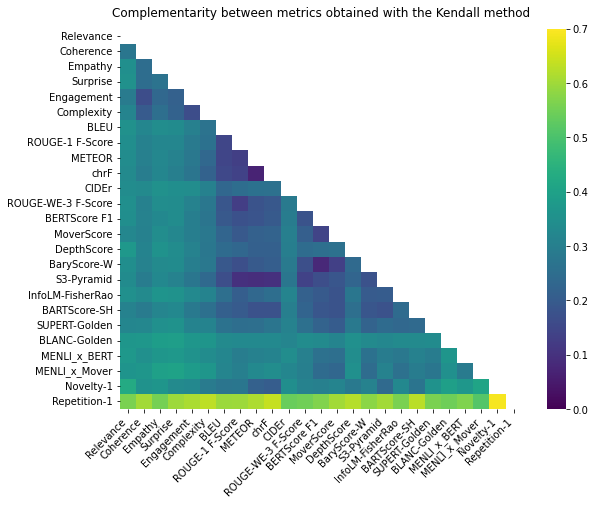

In [9]:
taukendall_complementarity_visualization(taukendall_corr, (9,7))

### Prediction of human metrics

In [10]:
dic_var = get_X_Y(df_complete, 'Relevance', False, list_model_MENLI, list_metric_AEM, list_metric_MENLI, list_metric_human)

Y = dic_var['Y']

lgbm_AEM = compute_lgb_reg(dic_var['X_AEM'], Y)
lgbm_human = compute_lgb_reg(dic_var['X_human'], Y)
lgbm_combined = compute_lgb_reg(dic_var['X_combined'], Y)

RMSE: 0.76
RMSE: 0.79
RMSE: 0.72


We plot the feature importance of the LGBM Model

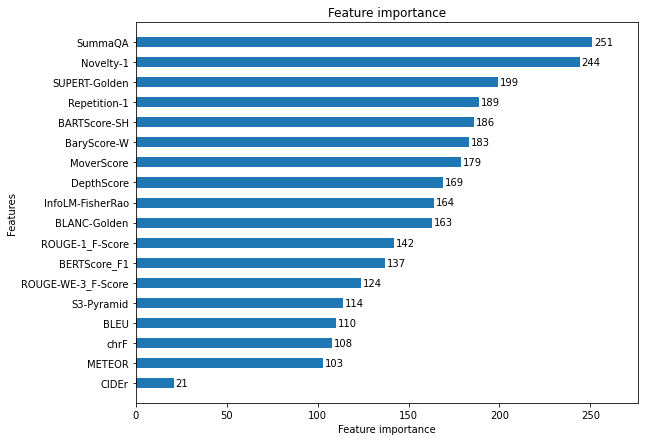

In [11]:
# plotting feature importance
lgb.plot_importance(lgbm_AEM[0], height=.5, figsize=(9,7), grid=False);

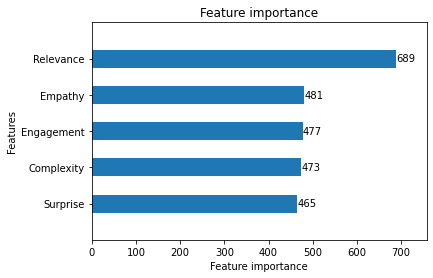

In [26]:
lgb.plot_importance(lgbm_human[0], height=.5, grid=False);

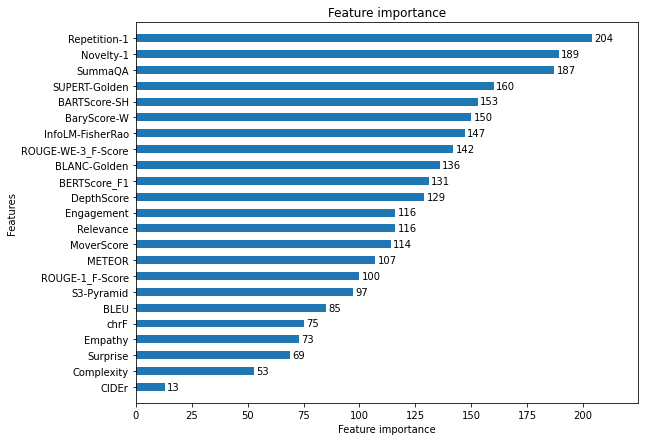

In [25]:
lgb.plot_importance(lgbm_combined[0], height=.5, figsize=(9,7), grid=False);

In [14]:
dic_var = get_X_Y(df_complete, 'Coherence', False, list_model_MENLI, list_metric_AEM, list_metric_MENLI, list_metric_human)
Y = dic_var['Y']

lgbm_AEM = compute_lgb_reg(dic_var['X_AEM'], Y)
lgbm_human = compute_lgb_reg(dic_var['X_human'], Y)
lgbm_combined = compute_lgb_reg(dic_var['X_combined'], Y)

RMSE: 0.65
RMSE: 0.48
RMSE: 0.40


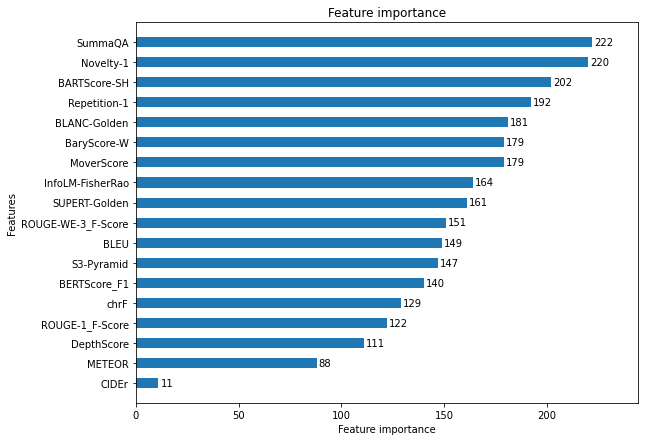

In [22]:
lgb.plot_importance(lgbm_AEM[0], height=.5, figsize=(9,7), grid=False);

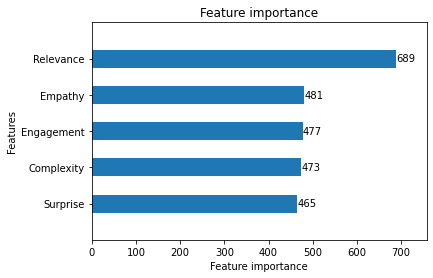

In [24]:
lgb.plot_importance(lgbm_human[0], height=.5, grid=False);

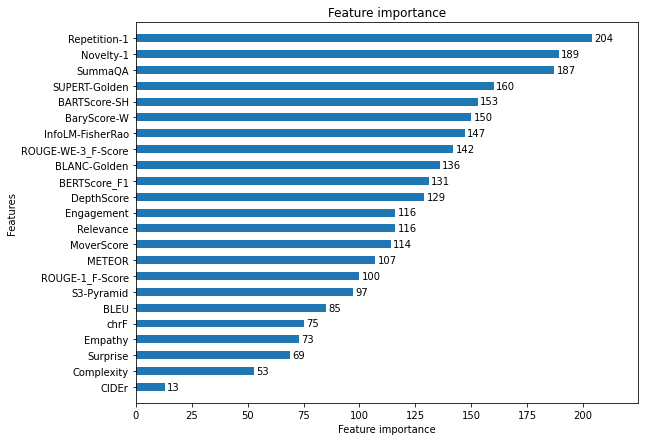

In [23]:
lgb.plot_importance(lgbm_combined[0], height=.5,figsize=(9,7), grid=False);

In [18]:
# We remove the two least relevant metrics for our predictions
del list_metric_AEM[list_metric_AEM.index('CIDEr')]
del list_metric_AEM[list_metric_AEM.index('chrF')]

In [19]:
for m in ['Relevance', 'Coherence']:
  dic = get_X_Y(df_complete, m, True, list_model_MENLI, list_metric_AEM, list_metric_MENLI, list_metric_human)
  lgbm_MENLI = compute_cv_lgb(dic['X_AEM'][['MENLI_x_BERT', 'MENLI_x_Mover']], dic['Y'])
  print(lgbm_MENLI)

{'RMSE': 0.9125915460273308}
{'RMSE': 0.7484384610133391}


In [20]:
get_scores(df_complete, "Relevance", list_model_MENLI, list_metric_AEM, list_metric_MENLI, list_metric_human)

Prédictions sans MENLI : 
Modèle avec métriques 'AEM' {'RMSE': 0.8549181138836979}
Modèle avec métriques 'human' {'RMSE': 0.805962517861696}
Modèle avec métriques 'combined' {'RMSE': 0.7479976972347024}

Prédictions avec MENLI : 
Modèle avec métriques 'AEM' {'RMSE': 0.8483299055931778}
Modèle avec métriques 'human' {'RMSE': 0.805962517861696}
Modèle avec métriques 'combined' {'RMSE': 0.7560784233575352}


In [21]:
get_scores(df_complete, "Coherence", list_model_MENLI, list_metric_AEM, list_metric_MENLI, list_metric_human)

Prédictions sans MENLI : 
Modèle avec métriques 'AEM' {'RMSE': 0.6183713809687225}
Modèle avec métriques 'human' {'RMSE': 0.44725889578555594}
Modèle avec métriques 'combined' {'RMSE': 0.4250137609016544}

Prédictions avec MENLI : 
Modèle avec métriques 'AEM' {'RMSE': 0.6251880183307069}
Modèle avec métriques 'human' {'RMSE': 0.44725889578555594}
Modèle avec métriques 'combined' {'RMSE': 0.4189020232483891}
